In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from utils.analysis_helpers import *

# Network (Single Topic/Doc) *Automatic* approach
Allow to have an overview of topics and their interactions.

**Pros:**
- Easy to see main themes across experiments.
- Straightforward network view of topic interactions.

**Cons:**
- Risk of false positives/negatives (due to the fact of forcing each docs (turn) into only one topic) 

In [35]:
df = pd.read_csv('./outputs/topics/df_topic_Compassion.csv')

# Palette for the topics
unique_topics = df['one_topic'].unique()
cmap = plt.get_cmap('tab20', len(unique_topics))
palette = {topic: mcolors.to_hex(cmap(i)) for i, topic in enumerate(sorted(unique_topics))}

In [36]:
df.head(2)

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker,one_topic,one_topic_name,multiple_topics,multiple_topics_name
0,S301final,3,the points i think are like meditating i could...,point meditate gear disturbing completely diss...,Compassion,1,301,Participant,4,4_reality_virtual_experiment_sensation,[4],['4_reality_virtual_experiment_sensation']
1,S301final,8,"to it was easier, yeah, to my inner self yes b...",easy inner self physical self easy myself,Compassion,1,301,Participant,8,8_self_easy_critical_aspect,[8],['8_self_easy_critical_aspect']


## Topic Network of the Entire Experiment

In addition to analyzing the topic network for the entire experiment, we can also explore topic networks within individual interviews. This would allow us to observe how exchanges evolve and how topics influence one another over time.

Furthermore, instead of focusing solely on the overall topic network for the entire experiment, we can examine the networks separately for each condition—Control and Intervention. This approach provides valuable insights into how conversational dynamics and topic interactions differ between the two conditions.

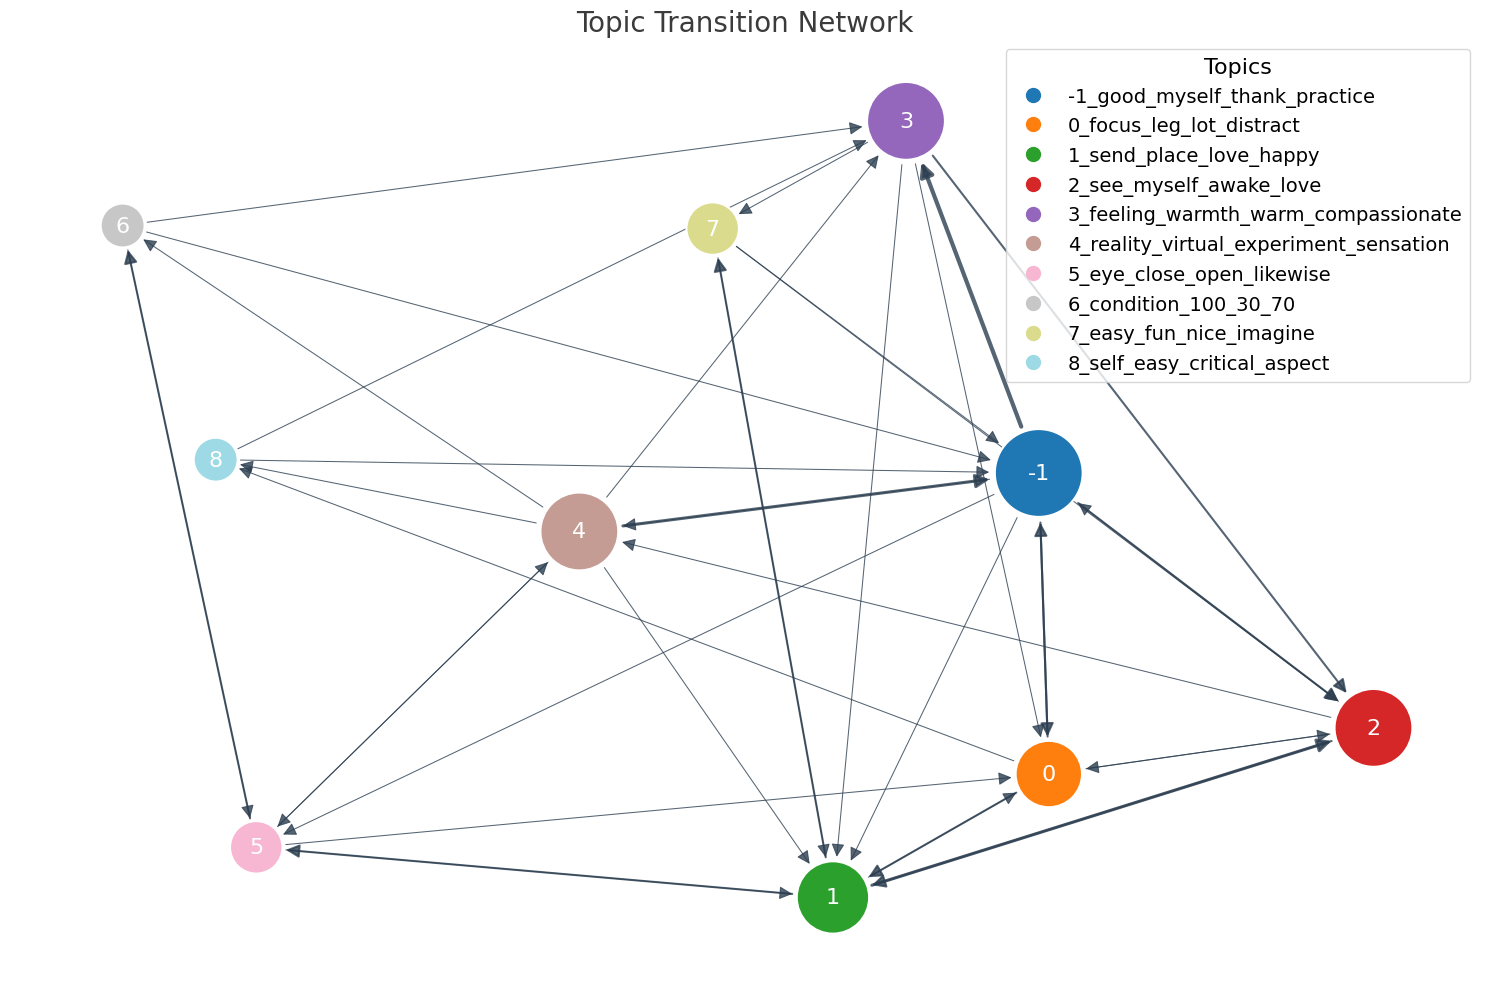

In [37]:
G = build_network_from_interviews(df, include_self_loops=False)
plot_topic_transition_network(G, show_edge_labels=False, palette=palette, size_by="appearance", file_name="images/topics_network.png") 
# size_by= appearance , occurrence, degree_centrality

- One single Interview

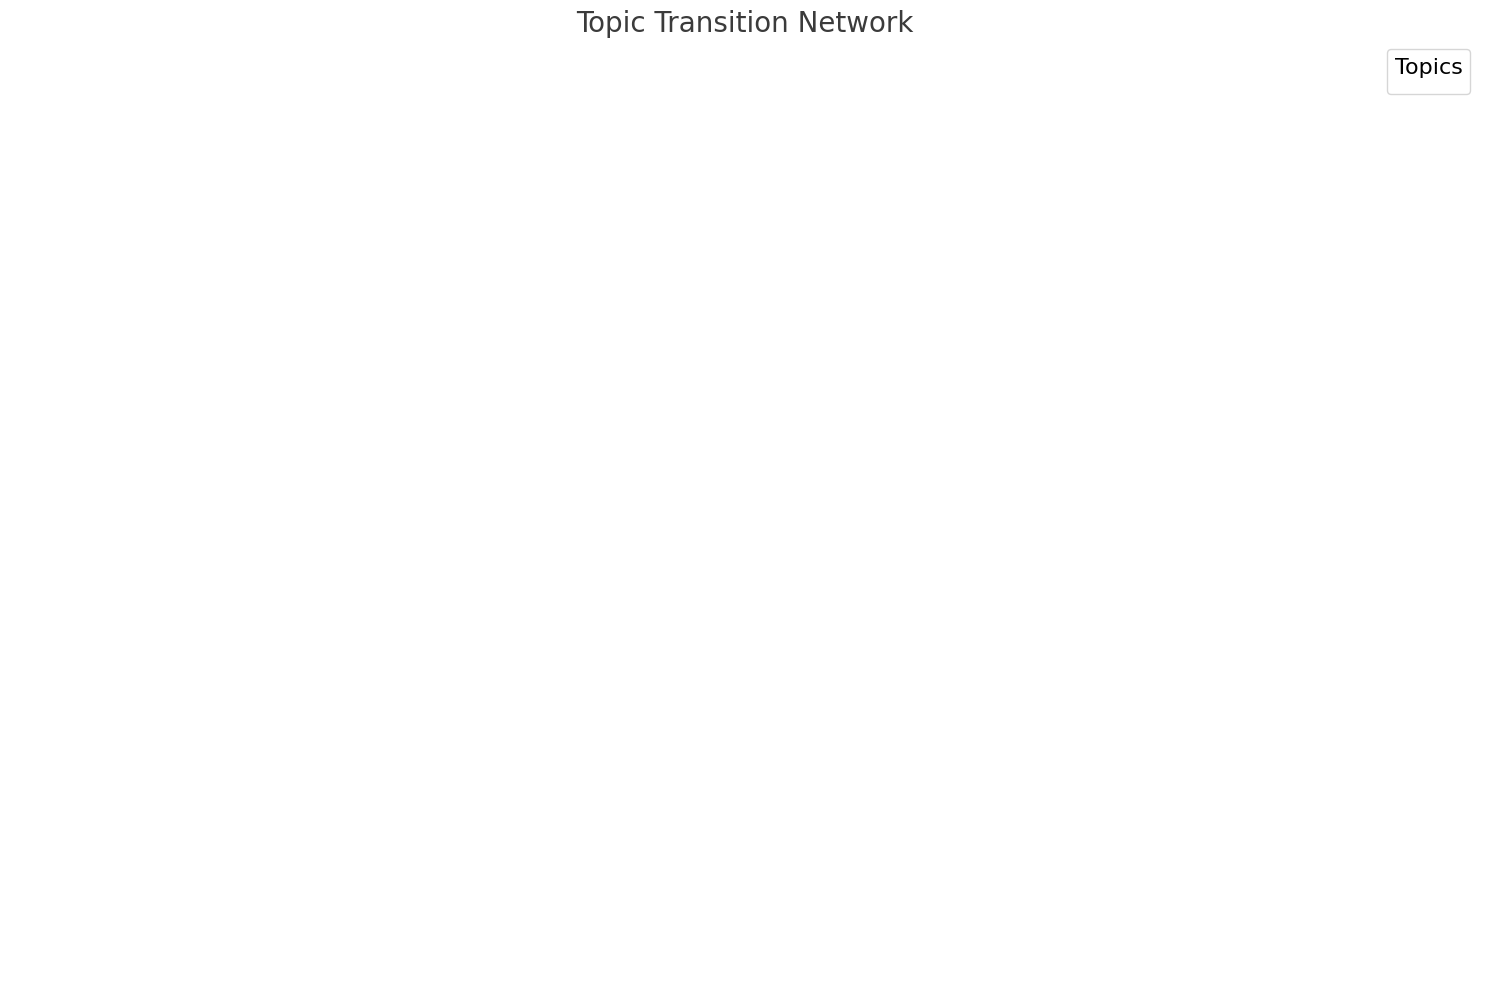

In [38]:
G_single = build_network_from_interviews(df[df["File Name"] == "S230 intervention"], include_self_loops=False)
plot_topic_transition_network(G_single, show_edge_labels=True,palette=palette, size_by="occurrence")

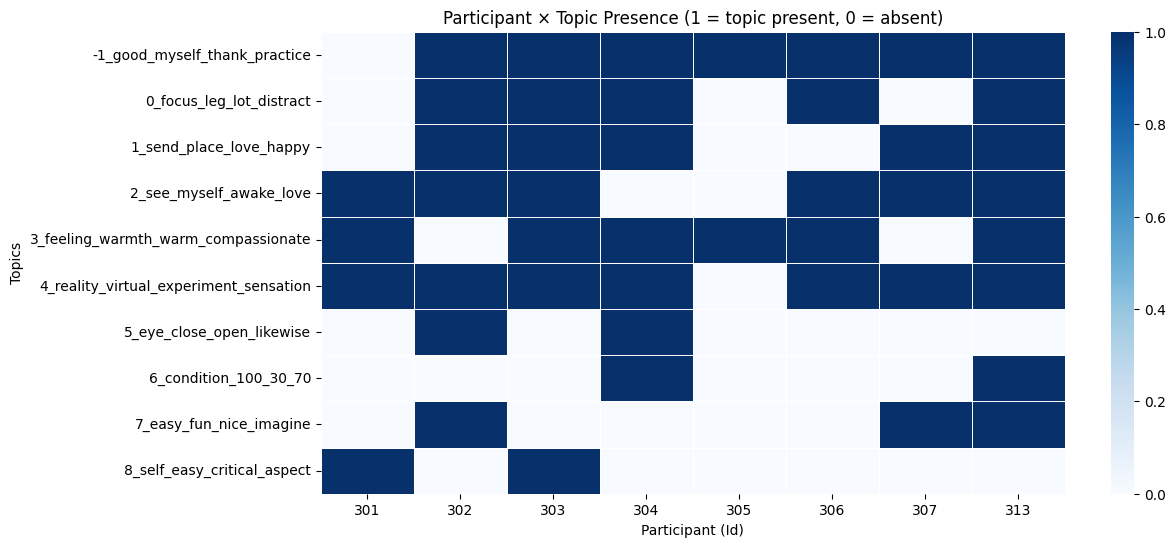

In [39]:
# 1. Count occurrences of each topic by participant
participant_topic_counts = (
    df.groupby(["Id", "one_topic_name"])["Content"]
    .size()
    .reset_index(name="Count")
)

# 2. Convert any Count > 0 to presence = 1
participant_topic_counts["Presence"] = (participant_topic_counts["Count"] > 0).astype(int)

# 3. Pivot to create a presence matrix
presence_matrix = participant_topic_counts.pivot(
    index="one_topic_name", 
    columns="Id", 
    values="Presence"
).fillna(0)

# 4. Visualize as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    presence_matrix, 
    cmap="Blues", 
    linewidths=.5,
)
plt.title("Participant × Topic Presence (1 = topic present, 0 = absent)")
plt.ylabel("Topics")
plt.xlabel("Participant (Id)")
plt.show()

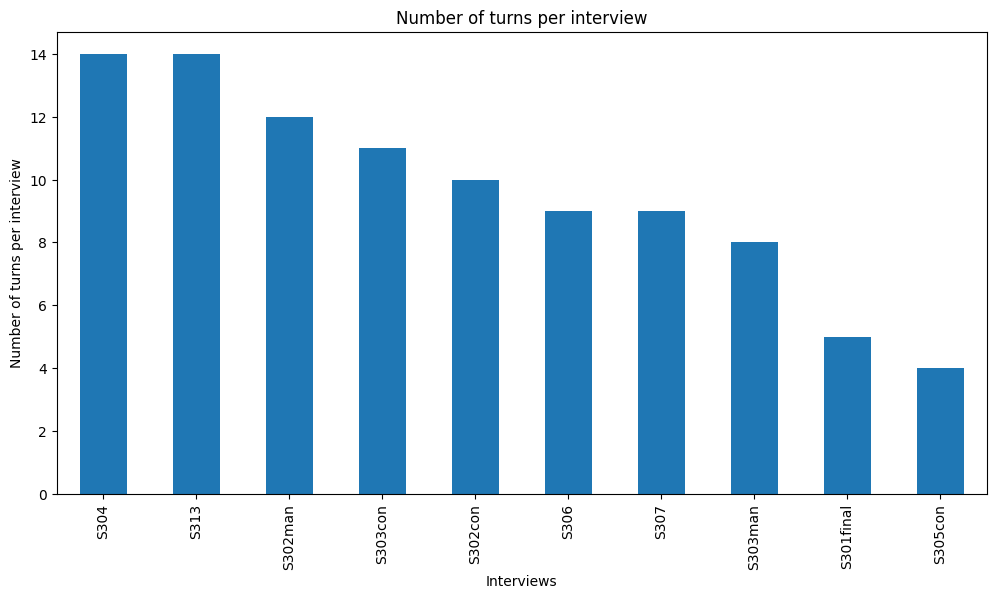

In [40]:
df["File Name"].value_counts().plot(kind="bar", figsize=(12, 6))
plt.ylabel("Number of turns per interview")
plt.xlabel("Interviews")
plt.title("Number of turns per interview")
plt.show()

# In-Depth (Multiple Topics/Turn) *Semi-Automatic* approach
We allow each turn to be labeled with multiple topics, which catches secondary or overlapping themes more accurately. However, it’s more complex to visualize and summarize, since a single turn can now connect to multiple topics.

This semi-automatic approach were instead of look at the overall distribution of topic, we can look to some specific topics that are interesting for the user.

In [41]:
def tag_topic(df, id_topic, exclude_indices, name_tag, multiple=False):
    single_topic_rows = df[df['one_topic'] == id_topic]
    multiple_topic_rows = df[df['multiple_topics'].map(lambda x: id_topic in x)]
    # Identify indices to tag from single topic or topics distribution
    rows_to_tag = single_topic_rows[~single_topic_rows.index.isin(exclude_indices)]
    if multiple:
        rows_to_tag = multiple_topic_rows[~multiple_topic_rows.index.isin(exclude_indices)]

    # Apply the tag
    df.loc[rows_to_tag.index, "tag"] = name_tag

def influence_analysis(topic_rows, tag_name):
    topic_rows = df[df['tag'] == tag_name]
    first_mentions = (
        topic_rows
        .sort_values(by='turn_index')
        .groupby('File Name', group_keys=False)
        .head(1)
        .reset_index(drop=True)
    )

    # Get participant IDs who mentioned the topic
    participant_rows = topic_rows[topic_rows['Speaker'] == 'Participant']
    participant_ids = participant_rows['Id'].unique()
    n_participants = len(participant_ids)

    # Find files where the Interviewer mentioned the topic first
    files_with_interviewer_first = first_mentions[first_mentions['Speaker'] == 'Interviewer']['File Name']

    # Count participants influenced by the Interviewer's first mention
    influenced_participants = participant_rows[
        participant_rows['File Name'].isin(files_with_interviewer_first)
    ]['Id'].unique()
    m_feedback = len(influenced_participants)

    # Print results
    print(f"Number of participants who mentioned the topic: {n_participants}")
    print(f"Participants who mentioned the topic: {list(participant_ids)}")

    print(f"Number of participants influenced by Interviewer mentioning the topic first: {m_feedback}")
    print(f"Participants influenced by Interviewer's first mention: {list(influenced_participants)}")

In [42]:
import ast

df = pd.read_csv("./outputs/topics/df_warm_tagged.csv")
# Re-convert 'multiple_topics' column strings to lists (lost during saving to csv)
df['multiple_topics'] = df['multiple_topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df.head(2)

,Experiment,File Name,Id,Content Type,Start Time,End Time,Speaker,Content,Condition,Order Condition,turn_index,Speaker_original,preprocessed_content,one_topic,one_topic_name,multiple_topics,multiple_topics_name,multiple_topics_list,Index,tag
0,Compassion,S301final,301,Audio,"00:00:00,060","00:00:12,100",Interviewer,And you can just a little bit tell about your ...,1,Unknown,0,Interviewer 1,tell experience section relax follow say help,17,17_experience_share_spot_problem,"[1, 8, 17]","['1_meditation_relax_guide_enjoy', '8_follow_g...","['1_meditation_relax_guide_enjoy', '8_follow_g...",0,NaN
1,Compassion,S301final,301,Audio,"00:00:12,320",00:00:23,Interviewer,There is no wrong or right to just saying your...,1,Unknown,1,Interviewer 2,wrong right say experience nice problem,17,17_experience_share_spot_problem,"[17, 31]","['17_experience_share_spot_problem', '31_corre...","['17_experience_share_spot_problem', '31_corre...",1,NaN


In [43]:
df.one_topic_name.unique()

array(['17_experience_share_spot_problem', '-1_image_mind_head_tiredness',
       '1_meditation_relax_guide_enjoy', '24_virtual_reality_room_gear',
       '4_focus_focused_manage_78', '0_eye_close_open_condition',
       '30_difference_big_main_compare',
       '5_compassion_meditation_compassionate_love',
       '3_great_nice_fine_pretty', '25_self_critical_inner_aspect',
       '21_happy_fun_feeling_compare', '12_warmth_warm_inside_chest',
       '31_correct_wrong_true_right',
       '32_notice_annoyed_particular_topic',
       '10_body_physical_weird_physically',
       '6_successful_feeling_thought_elicit', '19_send_love_body_avatar',
       '7_connect_helpful_recording_remember', '22_want_ask_share_elena',
       '16_time_later_spend_go', '29_hand_shoulder_raise_move',
       '33_thank___', '15_weird_probably_way_kinda',
       '20_experiment_lab_impression_interesting',
       '2_easy_explain_phrase_super', '18_avatar_embody_realize_cloud',
       '34_look_appear_specifically_bad

## Tag
After manual observation of interesting topic.

In [44]:
df["tag"] = None

### Index to select for tagging

In [45]:
list_index = [10,11,336,337,338,571,339,345,401]
df.loc[list_index, "tag"] = "heavy_light"

KeyError: '[571] not in index'

### Select all row from one topic minus some exclusion (after manual revision)

In [15]:
id_topic = 18
exclude_indices = [666]
tag_topic(df, id_topic, exclude_indices, "floating", multiple=False)

## Analyse the tagged data

In [22]:
df.tag.unique()

array([nan, 'heavy_light', 'floating', 'sleep', 'pixel_avatar'],
      dtype=object)

In [25]:
tag_name = "warm"
influence_analysis(df, tag_name)

Number of participants who mentioned the topic: 6
Participants who mentioned the topic: [301, 303, 304, 305, 306, 313]
Number of participants influenced by Interviewer mentioning the topic first: 3
Participants influenced by Interviewer's first mention: [301, 304, 313]


In [23]:
#df.to_csv("./topics/df_tagged.csv", index=False)